# How to Price Your Home
## A data exploration, modeling and evaluation using the Ames, Iowa housing sales dataset

### Overview

- Initial exploration
    - Exploration of the target variable
- Data preparation
- Modeling
    - Model-less baseline
    - Multiple linear regression
    - Ridge regression
- Discussion of next steps


Selling a home can be a torturous process. Homeowners rely on real estate agent's opinions and experience to guide them to the right decisions. So many questions haunt the homeowner. Are you pricing it right for the market? Are you pricing it to move quickly or get the maximum price?

My project aims to predict the sale price of houses using the [Ames, Iowa housing dataset](http://jse.amstat.org/v19n3/decock.pdf) produced by Dean De Cook, of Truman University in 2011. The training dataset used for this anaylsis was sourced from the [Advanced Regression Techniques Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview). 

I began with a baseline that predicts only the mean house price from the training data for each house, but this model does very poorly (of course). My final model is a Ridge regression model, which had an R2 Score of 0.78 and a MAE of $24,244.

### Data Description

The subset of the Ames, Iowa dataset includes 1,460 home sales and record 81 variables for each home. The variables describe the details of the home, its ammenities, the lot, the zoning, and descriptors of the type of sale itself. While many variables are not within the control of the homeowner, such as lot size or zoning, including them in the eventual model will be useful for controlling for the impact. 

#### Data Descisions

**Removed Observations**

I used the variable `SaleType`, to exclude new construction and estate trasfers from the analysis. I assumed that homeowners most interested in this analysis would be currently living _in_ their home and looking to sell. I then dropped the variable. Removing those home sales reduced the dataset to 1,295 observations.

Only 91 homes in the dataset were listed to have `Alley`s behind the house, and the values for that variable were "gravel", "paved", or missing. I created a new variable to just capture **if** the property was adjacent to the property and drop the original alley type variable.

**Removed Variables**

`Id` was removed, as it is a house identifier and not descriptive. 

A [full description of the variables](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=data_description.txt) in the dataset is available. 

In [1]:
# Imports
import pandas as pd
import numpy as np

# Visalization libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Data Preparation and Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# Evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Feature importance library
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Exploring nulls and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [8]:
df_used_homes.LandSlope.value_counts()

Gtl    1219
Mod      63
Sev      13
Name: LandSlope, dtype: int64

In [13]:
df.Alley.value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [19]:
df_used_homes = df.loc[~df.SaleType.str.contains("New|COD")].copy()
df_used_homes.drop(columns = ['SaleType'], inplace = True)
df_used_homes.shape

(1295, 80)

In [20]:
df_used_homes['HasAlley'] = 0
df_used_homes.Alley.fillna("not",inplace=True)
df_used_homes.loc[(df_used_homes.Alley.str.contains("Grvl|Pave")), 'HasAlley'] = 1
df_used_homes.drop(columns = ['Alley'], inplace=True)
df_used_homes.shape

(1295, 80)

In [30]:
na_count = df_used_homes.isna().sum().sort_values(ascending=False)
na_count[na_count>0]

PoolQC          1289
MiscFeature     1243
Fence           1027
FireplaceQu      625
LotFrontage      247
GarageType        79
GarageFinish      79
GarageQual        79
GarageCond        79
GarageYrBlt       79
BsmtExposure      37
BsmtFinType2      37
BsmtQual          36
BsmtCond          36
BsmtFinType1      36
MasVnrArea         5
MasVnrType         5
Electrical         1
dtype: int64

PoolQC          1289
MiscFeature     1243
Fence           1027
FireplaceQu      625
LotFrontage      247
GarageType        79
GarageFinish      79
GarageQual        79
GarageCond        79
GarageYrBlt       79
BsmtExposure      37
BsmtFinType2      37
BsmtQual          36
BsmtCond          36
BsmtFinType1      36
MasVnrArea         5
MasVnrType         5
Electrical         1
dtype: int64

In [5]:
# Evaluating the breakdown of each numeric column
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Explore Target Variable

The target variable shows that there are some outliers in the data, which are homes that were sold at much higher prices than most of the other homes in the dataset. I kept these outliers in, however may consider doing a transformation at some point to normalize the target variable. Alternatively, I could train my model without those outliers, with the understanding that then my model would only be accurate at homes that would be sold at prices less than a certain amount.

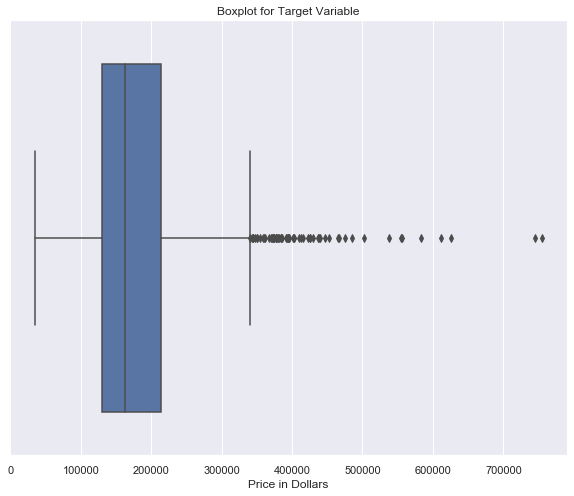

In [6]:
# plotting the distribution of the target variable with a boxplot
plt.figure(figsize=(10,8))
sns.boxplot(x=df['SalePrice'])
plt.title("Boxplot for Target Variable")
plt.xlabel("Price in Dollars")
plt.show()

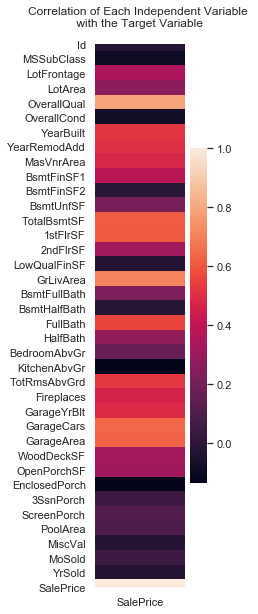

In [7]:
# plotting the correlation between variables and the target using a heatmap
plt.figure(figsize=(2,10))
sns.heatmap(df.corr()[['SalePrice']])
plt.title("Correlation of Each Independent Variable \n with the Target Variable \n")
plt.show()

The most correlated variable with the target is `OverallQual`, which captures the ranking of the Overall Quality of a home

In [16]:
test = df.groupby('OverallQual')['SalePrice'].mean()

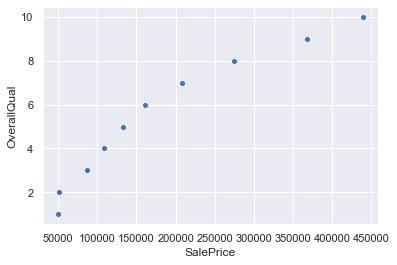

In [19]:
sns.scatterplot(test, test.index)

### Data Preparation



In [8]:
# Using only numeric columns
num_cols = list(df.dtypes[df.dtypes != 'object'].index)

In [9]:
# subsetting my dataframe
df_num = df[num_cols]
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [10]:
def summarize_dataframe(df):
    '''
    Summarizes each column in a Pandas dataframe, where each row of the 
    summary output is a column of the input dataframe, df
    Will show the datatype of data in the column, the number of missing values
    in that column, and the number of unique values in the column
    -
    Input:
    df : Pandas dataframe
    -
    Output:
    summary : Pandas dataframe, now showing column details
    '''
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index'] # name of each variable 
    summary = summary[['Name','dtypes']] # data type of each variable
    summary['Missing'] = df.isnull().sum().values # number of missing values  
    summary['Uniques'] = df.nunique().values # number of unique values
    return summary

In [11]:
summarize_dataframe(df_num)

,Name,dtypes,Missing,Uniques
0,Id,int64,0,1460
1,MSSubClass,int64,0,15
2,LotFrontage,float64,259,110
3,LotArea,int64,0,1073
4,OverallQual,int64,0,10
5,OverallCond,int64,0,9
6,YearBuilt,int64,0,112
7,YearRemodAdd,int64,0,61
8,MasVnrArea,float64,8,327
9,BsmtFinSF1,int64,0,637


In [12]:
# Dropping the three columns with null values: 
# LotFrontage, MasVnrArea and GarageYrBlt
df_num.dropna(axis=1, inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
# Splitting my data into X and Y
target = 'SalePrice'
used_cols = list(col for col in df_num.columns.to_list() if col not in [target, 'Id'])

X = df_num[used_cols]
y = df_num[target]

# Creating a split in my data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=42)

In [14]:
# Scaling my data
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modeling



#### Model-Less Baseline

I began with a baseline that predicts only the mean house price from the training data for each house, but this model does very poorly (of course). My final model is a Ridge regression model, which had an R2 Score of 0.78 and a MAE of $24,244.

I began with a model-less baseline which simply predicts the average sale price from the training set.

In [15]:
# Grabbing the target mean from the training data
y_mean_train = y_train.mean()

# Creating predictions for the train and test sets
baseline_y_pred_train = ([y_mean_train]*len(y_train))
baseline_y_pred_test = ([y_mean_train]*len(y_test))

In [16]:
# Evaluating my model-less baseline
# Checking the scores on both train and test set to look for overfitting
print(f"Training R2: {r2_score(y_train, baseline_y_pred_train)}")
print(f"Testing R2: {r2_score(y_test, baseline_y_pred_test)}")
print("---")
print(f"Training MAE: {mean_absolute_error(y_train, baseline_y_pred_train)}")
print(f"Testing MAE: {mean_absolute_error(y_test, baseline_y_pred_test)}")

Training R2: 0.0
Testing R2: -1.9765701703589045e-05
---
Training MAE: 56415.950564776824
Testing MAE: 59592.07556279647


#### Linear Regression Model

I then used a multiple linear regression model on my 33 numeric features that I already prepared and scaled.

In [17]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

In [19]:
print(f"Training R2: {r2_score(y_train, y_pred_train)}")
print(f"Testing R2: {r2_score(y_test, y_pred_test)}")
print("---")
print(f"Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
print(f"Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

Training R2: 0.8077421070813382
Testing R2: 0.7806408594154468
---
Training MAE: 21214.57938573137
Testing MAE: 24255.845000385987


#### Ridge Regression Model

Looking at the correlation between variables in the test set, I can see that there is correlation between features. I thus use a Ridge regression model to attempt to regularize away from the effects of that multicollinearity.

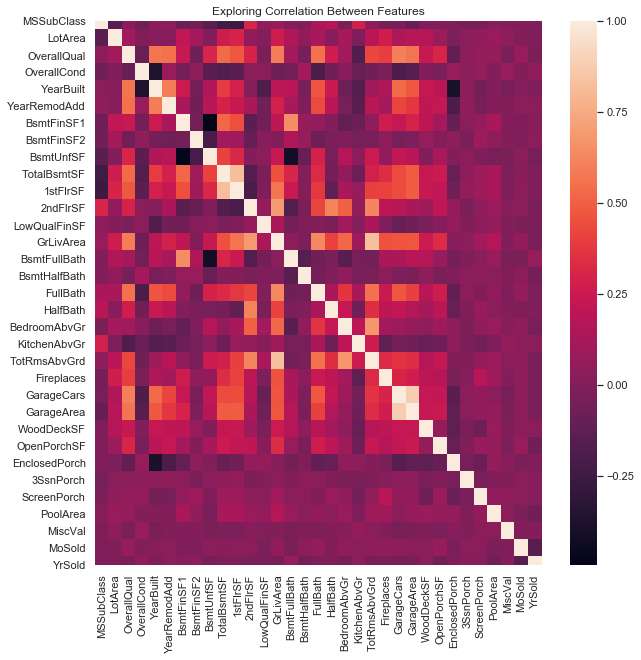

In [20]:
# plotting the correlation between features using a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df_num[used_cols].corr())
plt.title("Exploring Correlation Between Features")
plt.show()

In [21]:
ridge = Ridge(random_state=42)
ridge.fit(X_train_scaled, y_train)

ridge_y_pred_train = ridge.predict(X_train_scaled)
ridge_y_pred_test = ridge.predict(X_test_scaled)

In [22]:
print(f"Training R2: {r2_score(y_train, ridge_y_pred_train)}")
print(f"Testing R2: {r2_score(y_test, ridge_y_pred_test)}")
print("---")
print(f"Training MAE: {mean_absolute_error(y_train, ridge_y_pred_train)}")
print(f"Testing MAE: {mean_absolute_error(y_test, ridge_y_pred_test)}")

Training R2: 0.8077401253767008
Testing R2: 0.7806225954250052
---
Training MAE: 21200.764116853657
Testing MAE: 24244.663403493225


#### Checking Feature Importance

I'm using the eli5 library to do permutation importance to explore which feature was the most important to my Ridge regression model.

In [23]:
# printing the weights, aka importance, for each variable 
perm = PermutationImportance(ridge, random_state=1).fit(X_test_scaled, y_test)
eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top=None)

Weight,Feature
0.2365 ± 0.0108,OverallQual
0.0778 ± 0.0126,GrLivArea
0.0464 ± 0.0148,TotRmsAbvGrd
0.0276 ± 0.0037,GarageCars
0.0268 ± 0.0122,YearBuilt
0.0231 ± 0.0036,1stFlrSF
0.0172 ± 0.0087,MSSubClass
0.0158 ± 0.0043,2ndFlrSF
0.0128 ± 0.0017,BsmtFullBath
0.0123 ± 0.0061,BedroomAbvGr


Unsurprisingly, the most important feature to my Ridge regression model is the one which is most correlated with the target: `OverallQual`

### Next Steps

In the future I would like to first use more of the categorical features, and perhaps encode some of the discrete features I used in my final model. I would also like to then only use the most important features, perhaps by regularizing using both LASSO and Ridge through an ElasticNet model. I could also only use the top 5-10 features based on Permutation Importance. 

I'd also like to explore capping my training data so that I create a model that only works on houses priced up to a certain point. This would narrow the target audience of my model, but at the same time Could make it work better on houses that are priced within a specific range. Thus, if I received a result from my model outside that range I could know that my model is likely not accurately pricing that home and thus should be handled using different techniques or models. 